In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv("/content/drive/MyDrive/data/tabular-playground-series-apr-2022/train.csv")
y_train = pd.read_csv("/content/drive/MyDrive/data/tabular-playground-series-apr-2022/train_labels.csv")
test = pd.read_csv("/content/drive/MyDrive/data/tabular-playground-series-apr-2022/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/data/tabular-playground-series-apr-2022/sample_submission.csv")

In [3]:
FEATURE_COLUMNS = X_train.columns.tolist()[3:]

https://www.kaggle.com/code/ambrosm/tpsapr22-eda-which-makes-sense<br>
**EDA link**

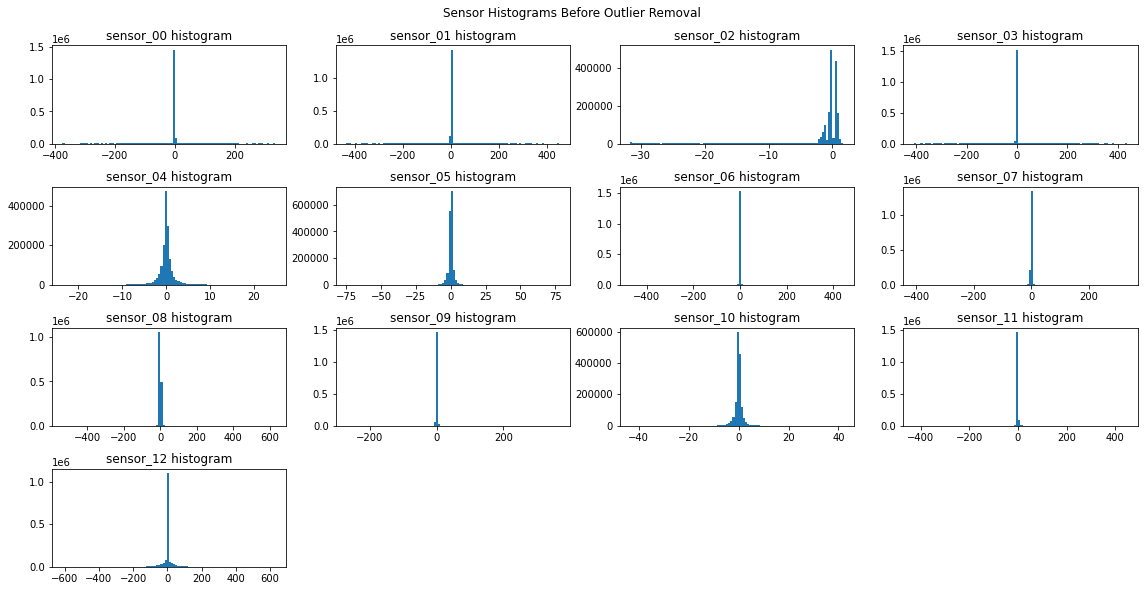

In [ ]:
# figure = plt.figure(figsize=(16, 8))
# for sensor in range(13):
#     sensor_name = f"sensor_{sensor:02d}"
#     plt.subplot(4, 4, sensor+1)
#     plt.hist(X_train[sensor_name], bins=100)
#     plt.title(f"{sensor_name} histogram")
# figure.tight_layout(h_pad=1.0, w_pad=0.5)
# plt.suptitle('Sensor Histograms Before Outlier Removal', y=1.02)
# plt.show()

In [ ]:
# from sklearn.preprocessing import QuantileTransformer

# scaler = QuantileTransformer(n_quantiles = 1000)
# X_train_trans = X_train[FEATURE_COLUMNS]
# X_train_scaled = scaler.fit_transform(X_train_trans)

In [ ]:
# X = pd.DataFrame(X_train_scaled, columns = FEATURE_COLUMNS)

# X_train[FEATURE_COLUMNS] = X

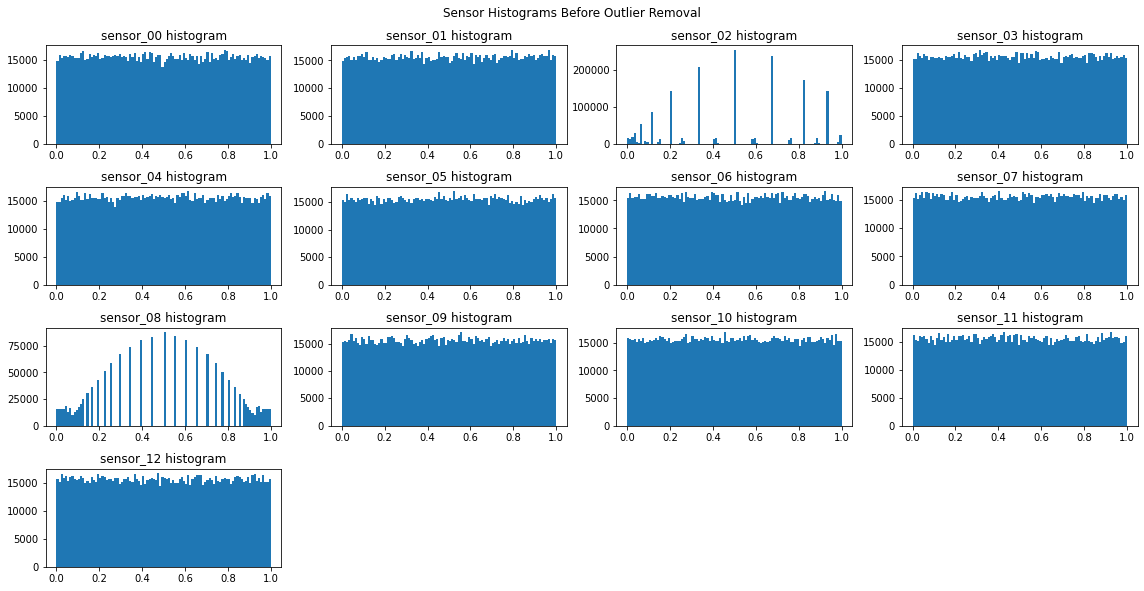

In [ ]:
# figure = plt.figure(figsize=(16, 8))
# for sensor in range(13):
#     sensor_name = f"sensor_{sensor:02d}"
#     plt.subplot(4, 4, sensor+1)
#     plt.hist(X_train[sensor_name], bins=100)
#     plt.title(f"{sensor_name} histogram")
# figure.tight_layout(h_pad=1.0, w_pad=0.5)
# plt.suptitle('Sensor Histograms Before Outlier Removal', y=1.02)
# plt.show()

In [4]:
sequencelist = []
for sequence, group in X_train.groupby("sequence"):
    sequence_features = group[FEATURE_COLUMNS]
    label = y_train[y_train.sequence == sequence].iloc[0].state
    
    sequencelist.append((sequence_features, label))
    

In [5]:
trans_sequencelist = []
for sequence, label in sequencelist:
  trans_sequence = np.transpose(sequence)
  X = pd.DataFrame(np.asarray(trans_sequence))
  trans_sequencelist.append((X, label))
  

In [ ]:
#torch.Tensor(trans_sequencelist[0][0].to_numpy()).reshape([13,60,1])

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import random
random.seed(42)
torch.manual_seed(42)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train_size = int(len(sequencelist) * 0.9) - int(len(sequencelist) * 0.9 % 60) 
train = sequencelist[:train_size]
train_cnn = trans_sequencelist[:train_size]
validation = sequencelist[train_size:]
val_cnn = trans_sequencelist[train_size:]

In [10]:
len(sequencelist)

25968

In [11]:
len(train)

23340

In [12]:
len(validation)

2628

In [13]:
class TrainDataset(Dataset):
  def __init__(self, sequences):
    self.sequences = sequences
  def __len__(self):
    return len(self.sequences)
  def __getitem__(self, idx):
    sequence, label = self.sequences[idx]
    sample = [torch.Tensor(sequence.to_numpy()).to(device), torch.tensor(label,dtype= torch.float32).to(device)]
    return sample

CNN에 들어갈 데이터는 센서가 13개이므로 13차원, 60 * 1 의 데이터로 만들어 주었다.

In [14]:
class CNNTrainDataset(Dataset):
  def __init__(self, sequences):
    self.sequences = sequences
  def __len__(self):
    return len(self.sequences)
  def __getitem__(self, idx):

    sequence, label = self.sequences[idx]
    sample = [torch.Tensor(sequence.to_numpy()).reshape([13,1,60]).to(device), torch.tensor(label,dtype= torch.float32).to(device)]
    return sample

In [15]:
Train_dataset = TrainDataset(train)
CNN_Train_dataset = CNNTrainDataset(train_cnn)
validation_dataset = TrainDataset(validation)
CNN_validation_dataset = CNNTrainDataset(val_cnn)

In [16]:
train_dataloader = DataLoader(Train_dataset, batch_size = 512, shuffle = True)
CNN_train_dataloader = DataLoader(CNN_Train_dataset, batch_size = 512, shuffle = True)
validation_dataloader = DataLoader(validation_dataset, batch_size=512, shuffle=False)
CNN_validation_dataloader = DataLoader(CNN_validation_dataset, batch_size=512, shuffle=False)


**LSTM**

In [72]:
from torch.nn.modules.normalization import LayerNorm

class LSTM(nn.Module):
    def __init__(self,
         seq_num = 60,
         input_dim = 13,
         lstm_dim = 512,
         num_layers = 2,
         num_classes = 1
    ):
        super().__init__()
        # self.layer1 = nn.Sequential(
        #     nn.LSTM(input_dim, lstm_dim, num_layers, batch_first=True, bidirectional=True),
        #     nn.LayerNorm([13, lstm_dim] ),
        #     nn.Dropout(0.5)
        # )
        # self.layer2 = nn.Sequential(
        #     nn.LSTM(2 * lstm_dim, 2 * lstm_dim, num_layers, batch_first=True, bidirectional=True),
        #     nn.LayerNorm(13),
        #     nn.Dropout(0.5)
        # )
        # self.layer3 = nn.Sequential(
        #     nn.LSTM(4 * lstm_dim, 4 * lstm_dim, num_layers, batch_first=True, bidirectional=True),
        #     nn.LayerNorm(13),
        #     nn.Dropout(0.5)
        # )
        self.lstm = nn.LSTM(input_dim, lstm_dim, num_layers, batch_first=True, bidirectional=True)
        
        self.lstm1 = nn.LSTM(2 * lstm_dim, 2 * lstm_dim, num_layers, batch_first=True, bidirectional=True)
        
        self.lstm2 = nn.LSTM(2 * lstm_dim, 2 * lstm_dim, num_layers, batch_first=True, bidirectional=True)
        
        self.logits = nn.Sequential(
            nn.Linear(lstm_dim * seq_num * 2, num_classes)
        )

    def forward(self, x):
        features, _ = self.lstm(x)
        #layer_norm = nn.LayerNorm(features.shape).to(device)
        #features = layer_norm(features.to(device)).to(device)
        features, _ = self.lstm1(features)
        #layer_norm = nn.LayerNorm(features.shape).to(device)
        #features = layer_norm(features.to(device)).to(device)
        features, _ = self.lstm2(features)
        # layer_norm = nn.LayerNorm(features.shape).to(device)
        # features = layer_norm(features.to(device)).to(device)
        features = features.reshape(features.shape[0], -1)
        pred = self.logits(features)
        return pred


CNN

In [62]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=13, out_channels = 32, kernel_size =(1,2), stride = 1),
        nn.BatchNorm2d(num_features=32),
        nn.Dropout(0.5),
        nn.Tanh(),
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (1,2), stride =1),
        nn.BatchNorm2d(64),
        nn.Dropout(0.5),
        nn.Tanh(),
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (1,2), stride =1),
        nn.BatchNorm2d(128),
        nn.Dropout(0.5),
        nn.Tanh(),
        nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (1,2), stride =1),
        nn.BatchNorm2d(256),
        nn.Dropout(0.5),
        nn.Tanh(),
        # nn.Conv2d(in_channels=256,out_channels=64,kernel_size=1, stride=1  ),
        # #nn.BatchNorm2d(64),
        # nn.Dropout(0.5),
        # nn.ReLU()
    )
    self.fc = nn.Linear(in_features= 256 * 56 * 1, out_features=64 ) 
    self.fc2 = nn.Linear(in_features= 64, out_features=32 ) 
    #처음 dense를 해줄때 나왔던 out채널의 수 그대로 해줘야됨.
    #in_features 헷갈리면 forward에 out.shape 쳐서 확인.
    self.fc3 = nn.Linear(in_features = 32, out_features = 16)
    self.fc4 = nn.Linear(16,2)


  def forward(self, x):
    out = self.layer1(x)
    #print(out.shape)
    out = out.view(-1, 256 * 56 * 1)
    
    out = self.fc(out)
    out = self.fc2(out)
    out = self.fc3(out)
    out = self.fc4(out)
    
    return out

In [73]:
model = LSTM().to(device)
CNN_model = CNN().to(device)

In [26]:
for i, data in enumerate(train_dataloader, 0):
  if( i > 0 ):
    break
  print(data[1])

tensor([1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
        0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
        1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 1., 0., 0., 

https://quokkas.tistory.com/37<br>
early stopping in pytorch(use pytorchtools)

In [21]:
#from pytorchtools import EarlyStopping
# 일단 안돼서 밑에 EarlyStoping 직접 구현한 코드. pytorchtools github에 나와있음.
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        

In [ ]:
from sklearn import metrics

**train for lstm**

In [75]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
early_stopping = EarlyStopping(patience = 7, verbose = True)
for epoch in range(500):
    
    running_loss = 0.0
    valid_loss = 0.0
    accuracy = 0

    model.train()

    #train model

    for i, data in enumerate(train_dataloader, 0):
        sequence = data[0]
        labels = data[1]

        optimizer.zero_grad() # 매개변수를 0으로 만듭니다. 매 학습시 초기화해줘야합니다.
        outputs = model(sequence).squeeze(-1) # 입력값을 넣어 순전파를 진행시킵니다.
        #outputs = torch.argmax(outputs).cpu()
        
        loss = criterion(outputs, labels) # 모델 출력값와 실제값을 손실함수에 대입합니다.
        loss.backward() # 손실함수에서 역전파 수행합니다.
        optimizer.step() # 옵티마이저를 사용해 매개변수를 최적화합니다.

        running_loss += loss.item()
        #_, predictions = torch.max(outputs,-1).to(torch.device('cpu'))

        # step_accuracy =  metrics.roc_curve(predictions, labels)

        # for label, prediction in zip(labels, predictions):
        #     if label == prediction:
        #         accuracy = accuracy + 1
    
    #valid model

    model.eval()
    with torch.no_grad():
      for i, data in enumerate(validation_dataloader, 0):
        sequence = data[0]
        labels = data[1]
        outputs = model(sequence).squeeze(-1)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()

    running_loss /= len(train_dataloader) 
    valid_loss /= len(validation_dataloader)

    early_stopping(valid_loss, model)
    if early_stopping.early_stop:
      print("Early stopping")
      break
    print(f'{epoch + 1} epoch loss: {running_loss:.3f}')
    print(f'{epoch + 1} valid epoch loss: {valid_loss:.3f}')
    #print(f'{epoch + 1} epoch accuracy: {accuracy / (i * 64):.3f}')

RuntimeError: ignored

**train for CNN-RF**

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience = 7, verbose = True)
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
for epoch in range(500):
    
    running_loss = 0.0
    valid_loss = 0.0
    accuracy = 0

    CNN_model.train()

    #train model

    for i, data in enumerate(CNN_train_dataloader, 0):
        sequence = data[0]
        labels = data[1]
        labels = labels.type(torch.int64)
        optimizer.zero_grad() # 매개변수를 0으로 만듭니다. 매 학습시 초기화해줘야합니다.
        outputs = CNN_model(sequence) # 입력값을 넣어 순전파를 진행시킵니다.
        
        #RF_model.fit(outputs.cpu().detach().numpy(), labels.cpu().detach().numpy())
        #predictions = RF_model.predict(outputs.cpu().detach().numpy())
        #predictions = torch.tensor(prediction).to(device)
        loss = criterion(outputs, labels) # 모델 출력값와 실제값을 손실함수에 대입합니다.
        loss.backward() # 손실함수에서 역전파 수행합니다.
        optimizer.step() # 옵티마이저를 사용해 매개변수를 최적화합니다.

        running_loss += loss.item()
        #_, predictions = torch.max(outputs,-1).to(torch.device('cpu'))

        #step_accuracy =  metrics.roc_curve(predictions, labels.cpu().detach().numpy())

        # for label, prediction in zip(labels, predictions):
        #      if label == prediction:
        #          accuracy = accuracy + 1
    
    #valid model

    CNN_model.eval()
    with torch.no_grad():
      for i, data in enumerate(CNN_validation_dataloader, 0):
        sequence = data[0]
        labels = data[1].type(torch.int64)
        
        outputs = CNN_model(sequence)
        #predictions = RF_model.predict(outputs.cpu().detach().numpy())
        loss = criterion(outputs, labels)
        valid_loss += loss.item()

    running_loss /= len(CNN_train_dataloader) 
    valid_loss /= len(CNN_validation_dataloader)

    early_stopping(valid_loss, CNN_model)
    if early_stopping.early_stop:
      print("Early stopping")
      break
    print(f'{epoch + 1} epoch loss: {running_loss:.3f}')
    print(f'{epoch + 1} valid epoch loss: {valid_loss:.3f}')
    #print(f'{epoch + 1} epoch accuracy: {accuracy / (i * 512):.3f}')

Validation loss decreased (inf --> 0.732986).  Saving model ...
1 epoch loss: 0.699
1 valid epoch loss: 0.733
Validation loss decreased (0.732986 --> 0.698149).  Saving model ...
2 epoch loss: 0.688
2 valid epoch loss: 0.698
EarlyStopping counter: 1 out of 7
3 epoch loss: 0.686
3 valid epoch loss: 0.769
EarlyStopping counter: 2 out of 7
4 epoch loss: 0.684
4 valid epoch loss: 0.810
EarlyStopping counter: 3 out of 7
5 epoch loss: 0.684
5 valid epoch loss: 0.775
EarlyStopping counter: 4 out of 7
6 epoch loss: 0.683
6 valid epoch loss: 0.706
EarlyStopping counter: 5 out of 7
7 epoch loss: 0.682
7 valid epoch loss: 0.774
EarlyStopping counter: 6 out of 7
8 epoch loss: 0.682
8 valid epoch loss: 0.728
EarlyStopping counter: 7 out of 7
Early stopping


In [ ]:
test

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,2.427357,19.639706,1.00000,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,8.0,-1.123555,-1.673048,10.980453,0.419011
1,25968,684,1,-4.950541,-21.747899,1.00000,0.983186,-0.569053,1.845924,-3.887978,1.727481,-2.9,0.395231,-0.882233,-1.871399,-0.008525
2,25968,684,2,1.136012,-10.756303,1.00000,1.016814,0.964157,2.454749,0.312386,1.154198,-5.6,1.114162,1.525273,-11.584362,0.139812
3,25968,684,3,0.806028,6.504202,1.00000,-0.179646,0.969221,-1.035153,-0.457195,0.254962,-2.7,-0.588873,0.608761,-4.241770,-0.462916
4,25968,684,4,1.288253,5.552521,1.00000,-0.493805,-1.036124,-1.126402,2.008197,-0.730534,0.0,0.899566,-1.259615,-0.472222,-0.121483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733075,38185,773,55,0.211747,2.005252,-1.33282,0.695575,-0.161327,-1.193717,0.421676,0.869466,0.0,-1.536850,0.388101,2.205761,-91.610827
733076,38185,773,56,-0.826121,-2.468487,-1.33282,0.381416,0.144745,1.060583,-0.765938,0.288550,0.2,-1.956647,-0.032158,-1.794239,72.414749
733077,38185,773,57,0.755023,1.469538,-1.33282,-1.253097,-0.414802,0.007479,0.907104,-1.556489,0.4,4.341763,0.150273,0.641975,-34.065644
733078,38185,773,58,-0.187017,0.714286,-1.33282,0.077876,1.323245,0.159312,-0.397996,0.306870,0.1,-1.013728,-0.608616,0.317901,65.659420


In [ ]:
submission

,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0
...,...,...
12213,38181,0
12214,38182,0
12215,38183,0
12216,38184,0


In [ ]:
test_sequencelist = []
for sequence, group in test.groupby("sequence"):
    sequence_features = group[FEATURE_COLUMNS]
    test_sequencelist.append(sequence_features)
    

In [ ]:
test_np = np.array(test_sequencelist)

In [ ]:
test_tensor = torch.tensor(test_np, dtype = torch.float32).to(device)

In [ ]:
test_tensor.size()

torch.Size([12218, 60, 13])

In [ ]:
model.eval()
with torch.no_grad():
  outputs = model(test_tensor)
  outputs = outputs.cpu()
  print(outputs)

tensor([[1.0532],
        [0.9383],
        [0.0611],
        ...,
        [0.4000],
        [0.0329],
        [0.8974]])


In [ ]:
pred = outputs.reshape(-1)
pred

tensor([1.0532, 0.9383, 0.0611,  ..., 0.4000, 0.0329, 0.8974])

In [ ]:
submission['state'] = pred.numpy()

In [ ]:
submission['state'].value_counts()

0.051910    3
0.880748    2
0.069326    2
0.054921    2
0.923273    2
           ..
0.784198    1
0.201705    1
0.898254    1
0.014080    1
0.897440    1
Name: state, Length: 12212, dtype: int64

In [ ]:
submission['state']

0        1.053186
1        0.938296
2        0.061111
3        0.656175
4        1.204153
           ...   
12213    0.258931
12214   -0.064379
12215    0.400024
12216    0.032853
12217    0.897440
Name: state, Length: 12218, dtype: float32

In [ ]:
submission['state'].value_counts(
)

0.051910    3
0.880748    2
0.069326    2
0.054921    2
0.923273    2
           ..
0.784198    1
0.201705    1
0.898254    1
0.014080    1
0.897440    1
Name: state, Length: 12212, dtype: int64

In [ ]:
submission.to_csv('sub6.csv',index=False)